In [1]:
!pip3 install transformers==4.4.1

     |████████████████████████████████| 2.1MB 12.5MB/s 
     |████████████████████████████████| 870kB 35.7MB/s 
     |████████████████████████████████| 3.3MB 56.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=cd0908a0d46a1fc3a6e1465f822c74e6a453190e837371c8486ce11f2bc6c15e
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' #Trying to reduce tensorflow warnings
import re
import math
import string
import time
import json
import random
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# specific machine learning functionality
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel

In [3]:
# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train = pd.read_csv("data/train.csv", sep='\t', index_col=False)
train_x = train["text"].values
train_y = train["label"].values

In [5]:
val = pd.read_csv("data/validation.csv", sep='\t', index_col=False)
validate_x = val["text"].values
validate_y = val["label"].values

In [6]:
# Standardize text util function
def standardize_text(input_text):
    # Convert to lowercase
    lowercase = tf.strings.lower(input_text)
    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [7]:
VOCABULARY_SIZE = 15000
SEQUENCE_SIZE = 256
EMBEDDING_SIZE = 100

max_features = 15000
sequence_length = 1000

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

data_x = list(train_x)
# Create the vocabulary of entire dataset
text_data = tf.data.Dataset.from_tensor_slices(data_x)

# Generate Text Vector
start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Execution time (mins) 0.004571441809336344
Vocabulary Size: 9342


In [8]:
# Check Vocabulary : 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

Vocabulary: ['', '[UNK]', 'the', 'of', 'in', 'and', 'to', 'a', 'for', 's', 'eur', 'is', 'company', 'will', 'from', 'on', 'its', 'with', 'has', 'by']
Vocabulary Size: 9342


In [9]:
def vectorize_text(text, label=None):
    text = tf.expand_dims(text, -1)
    text = text_vectorizer(text)
    if label is None:
        return text
    else:
        return text, label

In [10]:
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

def save_model(model, path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  if isinstance(model,TFBertForSequenceClassification):
    #model.save_pretrained(path)
    model.save_weights(os.path.join(path,model_name+".h5"))
  else:
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".h5")).st_size
  return model_size

In [11]:
def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, epochs,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(20,5))
  axs = fig.add_subplot(1,3,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,3,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
      # Save model
      save_model(model, model_name=model.name)
      model_size = get_model_size(model_name=model.name)

      # Save model history
      with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
          json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

      trainable_parameters = count_params(model.trainable_weights)
      non_trainable_parameters = count_params(model.non_trainable_weights)

      # Save model metrics
      metrics ={
          "trainable_parameters":trainable_parameters,
          "execution_time":execution_time,
          "loss":evaluation_results[0],
          "accuracy":evaluation_results[1],
          "model_size":model_size,
          "learning_rate":learning_rate,
          "epochs":epochs,
          "name": model.name,
          "id": int(time.time())
      }
      with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
          json_file.write(json.dumps(metrics,cls=JsonEncoder))

In [12]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

label2index = {"positive":2, "neutral": 1, "negative": 0}
num_classes = 3

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>


In [13]:
def build_simple_fcn(num_classes, sequence_length):
  # Set the model name as
  model_name = 'simple_fcn_'+str(int(time.time()))

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  hidden = keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

Model: "simple_fcn_1618744592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1025024   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 2,863,619
Trainable params: 2,863,619
Non-trainable params: 0
___________________________________

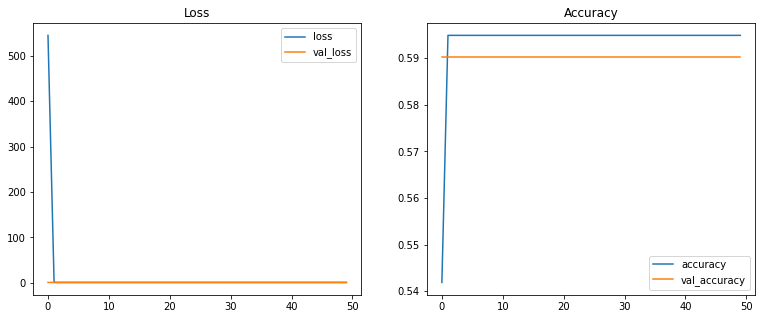

13/13 [==============================] - 0s 2ms/step - loss: 0.9364 - accuracy: 0.5902
[0.93638014793396, 0.5902062058448792]


In [14]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 50
sequence_length = 1000

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn(num_classes, sequence_length)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

In [15]:
def build_simple_fcn_with_emb(num_classes,sequence_length, vocab_size, embedding_dim):
    # Set the model name as
    model_name = 'simple_fcn_emb'+str(int(time.time()))

    # Model input
    model_input = keras.layers.Input(shape=(sequence_length))

    hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(model_input)
    hidden = keras.layers.Flatten()(hidden)
    hidden = keras.layers.Dense(1024, activation="relu")(hidden)
    hidden = keras.layers.Dense(512, activation="relu")(hidden)

    # Output Layer
    output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

    # Create model
    model = Model(inputs=model_input, outputs=output, name=model_name)

    return model

Model: "simple_fcn_emb1618744617"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         934200    
_________________________________________________________________
flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102401024 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 103,861,563
Trainable params: 103,861,563
Non-trainable params: 0
____________________________

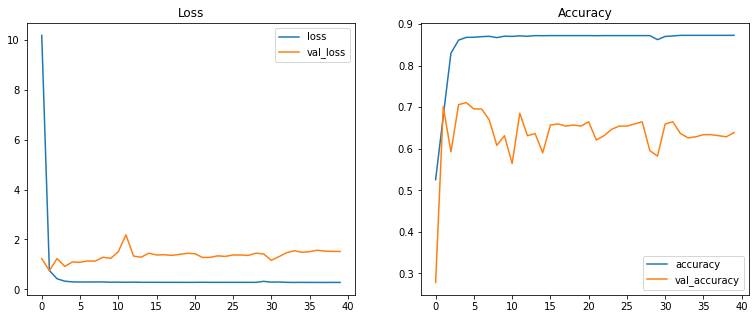

13/13 [==============================] - 0s 6ms/step - loss: 1.5205 - accuracy: 0.6392
[1.5205458402633667, 0.6391752362251282]


In [16]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 40
embedding_dim = 100
#sequence_length = 256

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn_with_emb(num_classes, sequence_length, vocabulary_size, embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

In [17]:
def build_conv1d_emb(num_classes,sequence_length, vocab_size, embedding_dim):
    # Set the model name as
    model_name = 'conv1d_emb_'+str(int(time.time()))

    # Model input
    model_input = keras.layers.Input(shape=(sequence_length))

    # Embedding Layer
    hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(model_input)

    # Conv1D + Global Max Pooling
    hidden = keras.layers.Conv1D(filters=256, kernel_size=5, padding="valid", activation="relu", strides=3)(hidden)
    hidden = keras.layers.GlobalMaxPooling1D()(hidden)

    # Dense Layer
    hidden = keras.layers.Dense(units=128, activation="relu")(hidden)

    # Output Layer
    output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

    # Create model
    model = Model(inputs=model_input, outputs=output, name=model_name)

    return model

Model: "conv1d_emb_1618744723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         934200    
_________________________________________________________________
conv1d (Conv1D)              (None, 332, 256)          128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,095,739
Trainable params: 1,095,739
Non-trainable params: 0
___________________________________

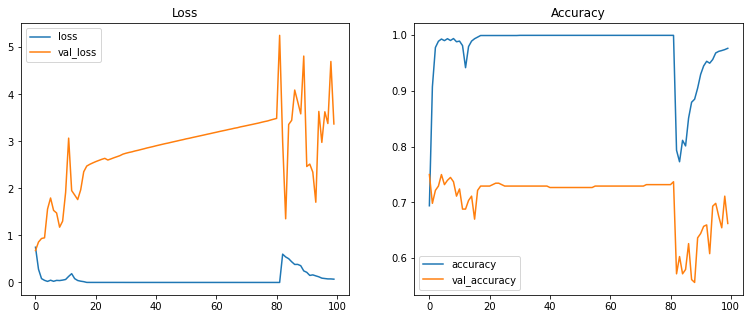

13/13 [==============================] - 0s 6ms/step - loss: 3.3700 - accuracy: 0.6624
[3.3700473308563232, 0.6623711585998535]


In [18]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 100
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_conv1d_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

### BERT

In [22]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [23]:
sequence_length = 256

# Train
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [24]:
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [25]:
batch_size = 8
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='int32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='int32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

In [26]:
#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>


In [27]:
#### your code here
def build_pretrained_bert(num_classes):
    # Set the model name as
    model_name = 'bert_pretrained_'+str(int(time.time()))
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes,name=model_name)
    
    return model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained_1618744945"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autogra

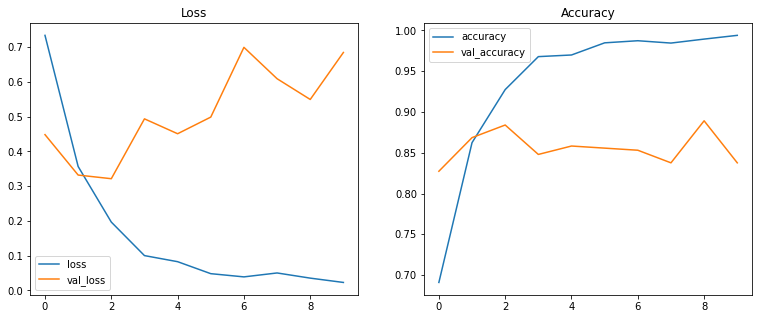

49/49 [==============================] - 3s 65ms/step - loss: 0.6841 - accuracy: 0.8376
[0.6840724945068359, 0.8376288414001465]


In [28]:
############################
# Training Params
############################
learning_rate = 2e-5
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

### Model Performance Analysis

In [30]:
models_store_path = "models"
from glob import glob

models_metrics_list = glob(models_store_path+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","loss",
                             "accuracy","learning_rate","epochs","name", "model_size",]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,loss,accuracy,learning_rate,epochs,name,model_size
2,"109,484,547",0.68,83.76%,0.00002,10,bert_pretrained_1618744945,438 MB
3,"1,095,739",3.37,66.24%,0.01000,100,conv1d_emb_1618744723,4 MB
1,"103,861,563",1.52,63.92%,0.01000,40,simple_fcn_emb1618744617,415 MB
0,"2,863,619",0.94,59.02%,0.01000,50,simple_fcn_1618744592,11 MB
